* 1 Constrained optimization using trust-constr
* 2 Constraint-free optimization using SLSQP

In [1]:
# %load_ext autoreload
# %autoreload 2
# %load_ext line_profiler
# %alias_magic t timeit
# %load_ext memory_profiler

In [2]:
import os

In [3]:
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

In [4]:
# import jax
# jax.config.update('jax_platform_name', 'cpu')
# jax.config.update("jax_enable_x64", False)
# import jax.numpy as jnp

In [5]:
import demes
import scipy
import pickle
import demesdraw
import sparse

import numpy as np
import matplotlib.pyplot as plt

import sys

from momi3.Params import Params
from momi3.MOMI import Momi

/mnt/turbo/eneswork/jthlab/momi3/src/momi3/utils.py:22: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [6]:
import jax
jax.devices()

[StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0)]

In [34]:
# Load demes graph
demo = demes.load(f"timing_tests_yaml/5_pop_2_admix.yaml")

In [35]:
sampled_demes = demo.metadata['sampled_demes']
sample_sizes = 5 * [6]

In [36]:
# Construct momi
momi = Momi(demo, sampled_demes=sampled_demes, sample_sizes=sample_sizes, jitted=True)

In [37]:
# Simulate a short strain
jsfs = momi.simulate_chromosome(
    sequence_length=1e7,
    recombination_rate=1e-8,
    mutation_rate=1e-8,
    low_memory=False,
    seed=108
)

In [43]:
# Construct a Params object
params = Params(momi)

In [44]:
params.set_train('eta_1', True)
params.set_train('eta_7', True)
params.set_train('eta_8', True)
params.set_train('eta_5', True)
params.set_train('eta_6', True)

params.set_train('tau_1', True)
params.set_train('tau_4', True)
params.set_train('tau_7', True)

params.set_train('pi_0', True)
params.set_train('pi_1', True)

In [45]:
true_parameters = params.theta_train_dict()

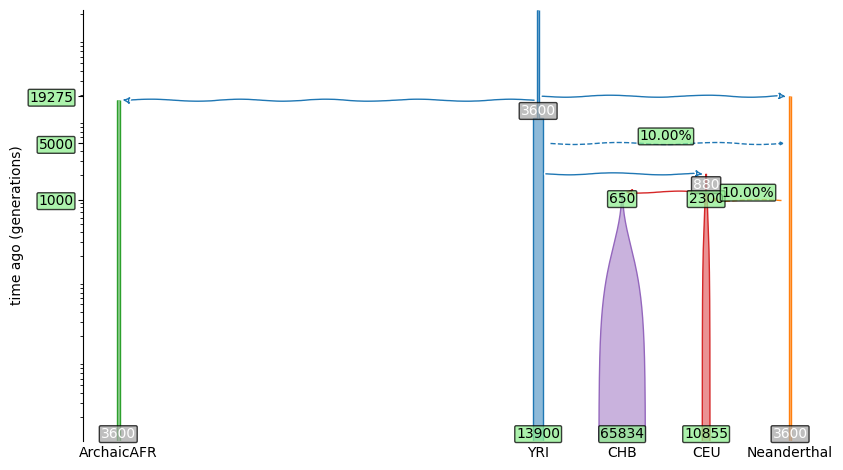

In [50]:
# We will infer greens
params.tubes(show_values=True, show_letters=False, log_time=True,
             tau_keys=['tau_1', 'tau_4', 'tau_7'])

In [53]:
%%time
momi.negative_loglik_with_gradient(params, jsfs)

CPU times: user 41 ms, sys: 7.13 ms, total: 48.1 ms
Wall time: 30.6 ms


(56521.94921875,
 {'eta_1': 0.033254530280828476,
  'tau_7': -0.11727027595043182,
  'eta_6': 0.010233603417873383,
  'eta_5': 0.07330276072025299,
  'eta_8': 0.0009561654878780246,
  'eta_7': 0.3874337673187256,
  'pi_0': 4215.1123046875,
  'tau_4': -0.07367650419473648,
  'pi_1': 3720.086669921875,
  'tau_1': -0.09113740921020508})

In [54]:
initial_dict = params.theta_train_dict()
train_keys = tuple(initial_dict)
theta_train_0 = np.array(list(initial_dict.values()))

In [55]:
# We'd like to minimize -\ell(theta_train; data)
def fun(theta_train, train_keys=train_keys):
    theta_train_dict = {}
    for key, val in zip(train_keys, theta_train):
        theta_train_dict[key] = float(val)
    val, grad = momi.negative_loglik_with_gradient(
        params, jsfs, theta_train_dict=theta_train_dict
    )
    grad = np.array(list(grad[key] for key in train_keys))
    return val, grad

In [56]:
# Evaluate the negative loglik value at theta_train_0 
val, grad = fun(theta_train_0)

print(f"Negative log likelihood: {float(val):.2f}")

print("="*10)

for key, d in zip(train_keys, theta_train_0):
    print(f"Value of {key}: {d:2f}")

print("="*10)
    
for key, d in zip(train_keys, grad):
    print(f"Derivative of {key}: {d:2f}")

Negative log likelihood: 56521.95
Value of eta_1: 13900.000000
Value of eta_5: 2300.000000
Value of eta_6: 10855.080952
Value of eta_7: 650.000000
Value of eta_8: 65834.770011
Value of pi_0: 0.100000
Value of pi_1: 0.100000
Value of tau_1: 1000.000000
Value of tau_4: 5000.000000
Value of tau_7: 19275.862069
Derivative of eta_1: 0.033255
Derivative of eta_5: 0.073303
Derivative of eta_6: 0.010234
Derivative of eta_7: 0.387434
Derivative of eta_8: 0.000956
Derivative of pi_0: 4215.112305
Derivative of pi_1: 3720.086670
Derivative of tau_1: -0.091137
Derivative of tau_4: -0.073677
Derivative of tau_7: -0.117270


# 1 Constrained Optimization

In [60]:
# You can add linear constraints easiliy

# Suppose you want CEU CHB divergence to be less than 1000 gen
params.add_linear_constraint('tau_1<=1000')

In [63]:
# Suppose you want neanderthal -> OOA proportion to be twice to,e larger than YRI -> Nea

# Below will throm an error Constraints should hold when you are assigning them
# params.add_linear_constraint('2*pi_0<=pi_1')

params.set('pi_0', 0.05)
params.add_linear_constraint('2*pi_0<=pi_1')

In [75]:
# Optimizer spesifications:
method = "trust-constr"
optimizer_options = dict(initial_tr_radius=1e-7, verbose=3)

# momi model constraints:
LinearConstraints = params._linear_constraints_for_scipy()

In [76]:
# Running the scipy optimizer
with jax.debug_nans(True):
    res = scipy.optimize.minimize(
        fun=fun,
        x0=theta_train_0,
        jac=True,
        constraints=LinearConstraints,
        method=method,
        options=optimizer_options,
    )

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  | penalty  |barrier param|CG stop|
|-------|-------|-------|-------------|----------|----------|----------|----------|-------------|-------|
|   1   |   1   |   0   | +5.6522e+04 | 1.00e-07 | 1.70e+03 | 1.00e-01 | 1.00e+00 |  1.00e-01   |   0   |
|   2   |   2   |   1   | +5.6522e+04 | 2.00e-07 | 1.70e+03 | 1.00e-01 | 1.00e+00 |  1.00e-01   |   2   |
|   3   |   3   |   2   | +5.6522e+04 | 4.00e-07 | 1.70e+03 | 1.00e-01 | 1.00e+00 |  1.00e-01   |   2   |
|   4   |   4   |   3   | +5.6522e+04 | 2.80e-06 | 1.70e+03 | 1.00e-01 | 1.00e+00 |  1.00e-01   |   2   |
|   5   |   5   |   4   | +5.6522e+04 | 1.96e-05 | 1.70e+03 | 1.00e-01 | 1.00e+00 |  1.00e-01   |   2   |
|   6   |   6   |   5   | +5.6522e+04 | 1.37e-04 | 1.70e+03 | 1.00e-01 | 1.00e+00 |  1.00e-01   |   2   |
|   7   |   7   |   6   | +5.6522e+04 | 9.60e-04 | 1.70e+03 | 1.00e-01 | 1.00e+00 |  1.00e-01   |   2   |
|   8   |   8   |   7   | +5.6520e+04 | 6.72e-

/home/enes/enesenv/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


|  53   |  55   |  229  | +5.5981e+04 | 9.91e+00 | 3.88e-01 | 0.00e+00 | 6.90e+03 |  1.00e-01   |   4   |
|  54   |  56   |  236  | +5.5981e+04 | 9.91e+00 | 3.88e-01 | 0.00e+00 | 6.90e+03 |  1.00e-01   |   4   |
|  55   |  57   |  243  | +5.5981e+04 | 9.91e+00 | 3.88e-01 | 0.00e+00 | 6.90e+03 |  1.00e-01   |   4   |
|  56   |  58   |  250  | +5.5981e+04 | 9.91e+00 | 3.88e-01 | 0.00e+00 | 6.90e+03 |  1.00e-01   |   4   |
|  57   |  59   |  257  | +5.5981e+04 | 9.91e+00 | 3.87e-01 | 0.00e+00 | 6.90e+03 |  1.00e-01   |   4   |
|  58   |  60   |  264  | +5.5981e+04 | 9.91e+00 | 3.83e-01 | 0.00e+00 | 6.90e+03 |  1.00e-01   |   4   |
|  59   |  61   |  271  | +5.5980e+04 | 1.55e+01 | 3.74e-01 | 0.00e+00 | 6.90e+03 |  1.00e-01   |   4   |
|  60   |  62   |  276  | +5.5980e+04 | 1.55e+01 | 3.74e-01 | 0.00e+00 | 6.90e+03 |  1.00e-01   |   4   |
|  61   |  63   |  284  | +5.5976e+04 | 7.35e+01 | 3.23e-01 | 0.00e+00 | 6.90e+03 |  1.00e-01   |   4   |
|  62   |  64   |  292  | +5.5969e+04 | 1.05e+

|  134  |  135  |  916  | +5.5821e+04 | 5.37e+03 | 4.38e-02 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   1   |
|  135  |  136  |  926  | +5.5820e+04 | 5.37e+03 | 9.79e-02 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   1   |
|  136  |  137  |  936  | +5.5819e+04 | 5.37e+03 | 4.37e-02 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   1   |
|  137  |  138  |  946  | +5.5818e+04 | 5.37e+03 | 9.92e-02 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   1   |
|  138  |  139  |  956  | +5.5817e+04 | 5.37e+03 | 4.36e-02 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   1   |
|  139  |  140  |  966  | +5.5817e+04 | 5.37e+03 | 1.01e-01 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   1   |
|  140  |  141  |  976  | +5.5816e+04 | 5.37e+03 | 4.34e-02 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   1   |
|  141  |  142  |  986  | +5.5815e+04 | 5.37e+03 | 1.02e-01 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   1   |
|  142  |  143  |  994  | +5.5814e+04 | 5.37e+03 | 4.33e-02 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   4   |
|  143  |  144  | 1004  | +5.5801e+04 | 5.91e+

|  217  |  233  | 1273  | +5.5786e+04 | 1.00e-09 | 3.92e-02 | 0.00e+00 | 1.00e+00 |  1.02e-08   |   2   |
|  218  |  234  | 1273  | +5.5786e+04 | 1.00e-07 | 3.92e-02 | 0.00e+00 | 1.00e+00 |  2.05e-09   |   0   |
|  219  |  235  | 1274  | +5.5786e+04 | 1.00e-08 | 3.92e-02 | 0.00e+00 | 1.00e+00 |  2.05e-09   |   2   |
|  220  |  236  | 1275  | +5.5786e+04 | 1.00e-09 | 3.92e-02 | 0.00e+00 | 1.00e+00 |  2.05e-09   |   2   |

`xtol` termination condition is satisfied.
Number of iterations: 220, function evaluations: 236, CG iterations: 1275, optimality: 3.92e-02, constraint violation: 0.00e+00, execution time:  4.3 s.


In [77]:
theta_train_hat = res.x
theta_train_hat = dict(zip(train_keys, theta_train_hat))
for key, d in theta_train_hat.items():
    print(f"\hat{{{key}}}: {d:2f}")

\hat{eta_1}: 11031.241977
\hat{eta_5}: 2764.924032
\hat{eta_6}: 10132.300977
\hat{eta_7}: 202.036059
\hat{eta_8}: 65995.761302
\hat{pi_0}: 0.022417
\hat{pi_1}: 0.071906
\hat{tau_1}: 1000.000000
\hat{tau_4}: 5546.855396
\hat{tau_7}: 23052.196357


In [78]:
params.set_optimization_results(theta_train_hat)

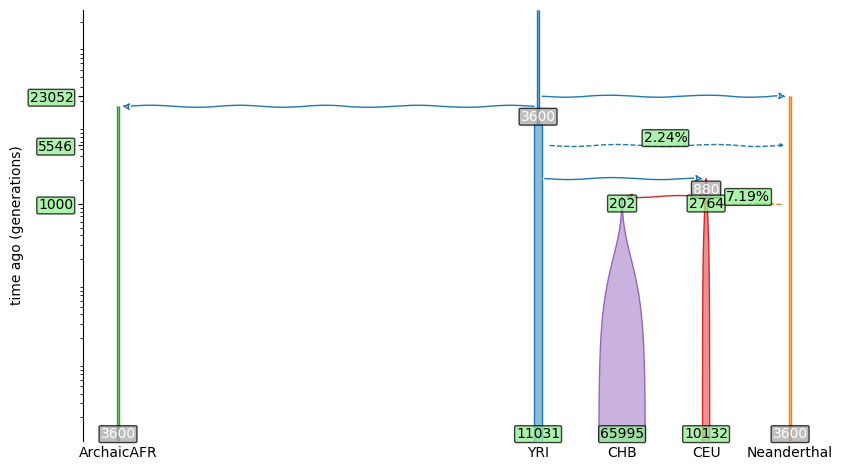

In [80]:
# We will infer greens
params.tubes(show_values=True, show_letters=False, log_time=True,
             tau_keys=['tau_1', 'tau_4', 'tau_7'])

In [81]:
# Get godombe
std_dev = momi.GIM_uncert(params, jsfs)

In [98]:
from momi3.utils import halfsigmoid
color_intensity_function = lambda x: halfsigmoid(x, scale=1e-8)

In [99]:
color_intensity_function(1e-8)

0.4621171572600098

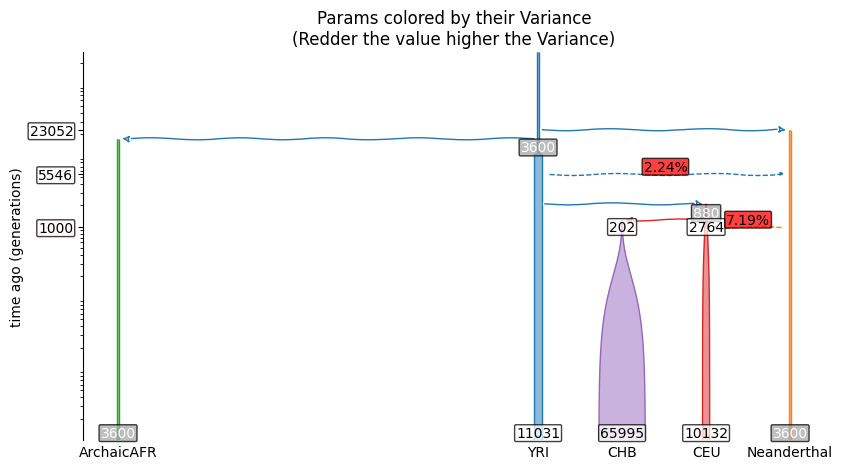

In [100]:
# You can visulize their standard devs

params.tubes(
    show_values=True, show_letters=False, log_time=True,
     tau_keys=['tau_1', 'tau_4', 'tau_7'],
    USER_DICT=std_dev,
    color_intensity_function=color_intensity_function
)

plt.title("Params colored by their Variance\n(Redder the value higher the Variance)");

# 2 Constraint Free Optimization
This relies on parameter transformation

In [115]:
# reset the params
params = momi._default_params

In [117]:
params.set_train('eta_1', True)
params.set_train('eta_7', True)
params.set_train('eta_8', True)
params.set_train('eta_5', True)
params.set_train('eta_6', True)

params.set_train('tau_1', True)
params.set_train('tau_4', True)
params.set_train('tau_7', True)

params.set_train('pi_0', True)
params.set_train('pi_1', True)

In [118]:
initial_dict = params.theta_train_dict(transformed=True)
train_keys = tuple(initial_dict)
theta_train_0 = np.array(list(initial_dict.values()))

In [119]:
# We'd like to minimize -\ell(theta_train; data)
def fun(theta_train, train_keys=train_keys):
    theta_train_dict = {}
    for key, val in zip(train_keys, theta_train):
        theta_train_dict[key] = float(val)
    val, grad = momi.negative_loglik_with_gradient(
        params, jsfs, theta_train_dict=theta_train_dict, transformed=True
    )
    grad = np.array(list(grad[key] for key in train_keys))
    return val, grad

In [120]:
# Evaluate the negative loglik value at theta_train_0 
val, grad = fun(theta_train_0)

print(f"Negative log likelihood: {float(val):.2f}")

print("="*10)

for key, d in zip(train_keys, theta_train_0):
    print(f"Value of {key}: {d:2f}")

print("="*10)
    
for key, d in zip(train_keys, grad):
    print(f"Derivative of {key}: {d:2f}")

Negative log likelihood: 56521.95
Value of softplus(eta_1): 13900.000000
Value of softplus(eta_5): 2300.000000
Value of softplus(eta_6): 10855.080952
Value of softplus(eta_7): 650.000000
Value of softplus(eta_8): 65834.770011
Value of logit(pi_0): -2.197225
Value of logit(pi_1): -2.197225
Value of log(tau_1-tau_0): 6.907755
Value of log(tau_2-tau_1): 5.486370
Value of log(tau_4-tau_3): 7.974841
Value of log(tau_5-tau_4): 8.583885
Value of log(tau_7-tau_6): 7.634804
Derivative of softplus(eta_1): 0.033254
Derivative of softplus(eta_5): 0.073303
Derivative of softplus(eta_6): 0.010234
Derivative of softplus(eta_7): 0.387434
Derivative of softplus(eta_8): 0.000956
Derivative of logit(pi_0): 379.359314
Derivative of logit(pi_1): 334.806122
Derivative of log(tau_1-tau_0): 637.975891
Derivative of log(tau_2-tau_1): 175.992767
Derivative of log(tau_4-tau_3): 23.735050
Derivative of log(tau_5-tau_4): 437.428467
Derivative of log(tau_7-tau_6): -242.627686


In [128]:
# Force events to be at least exp(3) generations apart

res = scipy.optimize.minimize(
    fun=fun,
    x0=theta_train_0,
    jac=True,
    method="SLSQP",
    bounds=7 * [[None, None]] + 5*[[3., None]]
)

In [130]:
theta_train_hat = res.x
theta_train_hat = dict(zip(train_keys, theta_train_hat))
for key, d in theta_train_hat.items():
    print(f"\hat{{{key}}}: {d:2f}")

\hat{softplus(eta_1)}: 13705.106813
\hat{softplus(eta_5)}: 347.688153
\hat{softplus(eta_6)}: 10629.192156
\hat{softplus(eta_7)}: 195.449626
\hat{softplus(eta_8)}: 65839.573217
\hat{logit(pi_0)}: -3.733677
\hat{logit(pi_1)}: -2.474964
\hat{log(tau_1-tau_0)}: 6.291194
\hat{log(tau_2-tau_1)}: 6.118526
\hat{log(tau_4-tau_3)}: 8.264242
\hat{log(tau_5-tau_4)}: 6.684017
\hat{log(tau_7-tau_6)}: 8.546783


In [131]:
# This function automatically detects if a transformed theta_hat is given and applies the inverse of it
params.set_optimization_results(theta_train_hat)

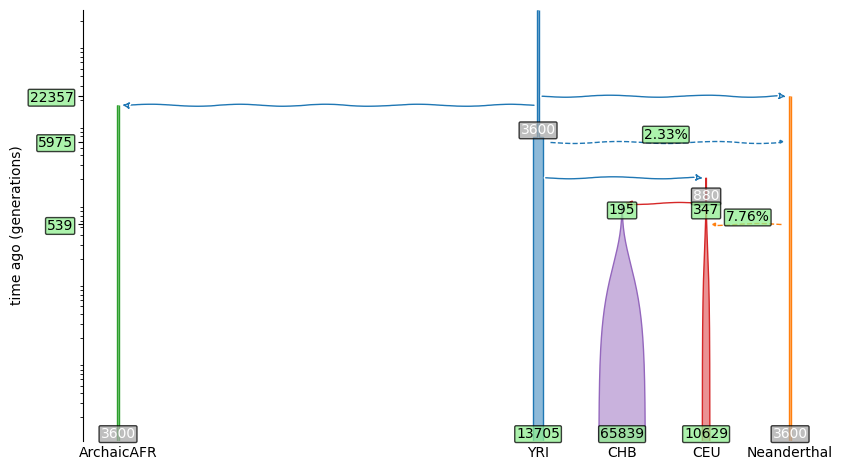

In [132]:
params.tubes(show_values=True, show_letters=False, log_time=True,
             tau_keys=['tau_1', 'tau_4', 'tau_7'])